In [1]:
import torch
from torchvision.transforms import v2

from SSD_trainer import ConditionalIoUCrop

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
import numpy as np

import CarImageClass
from SSD_from_scratch import mySSD

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"

In [2]:
# load training data
train_data = CarImageClass.ImageClass(targ_dir=train_path, file_list=None, transform=None, file_pct=1, rand_seed=724, include_area=True)

In [ ]:
ckpt_path = r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\saved_models\L1Loss_mAP_432_11_15_2025.ckpt"
out_path  = r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\saved_models\weight_only_mAP_432_11_15_2025.pth"

# 1) Load the checkpoint as a raw dict
ckpt = torch.load(ckpt_path, map_location="cpu")  # weights_only=False is default

# 2) Inspect keys if you want
print(ckpt.keys())  # should include: 'model_state', 'optimizer_state', ...

# 3) Extract the model state_dict
state_dict = ckpt["model_state"]

# 4) Save a clean weights-only file
torch.save(state_dict, out_path)

print(f"Saved weights-only state_dict to {out_path}")


C:\Users\eblac\AppData\Local\Temp\ipykernel_4012\3936211859.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")  # weights_o

dict_keys(['epoch', 'model_state', 'optimizer_state', 'scheduler_state', 'scaler_state', 'best_metric', 'rng_state', 'loss_dict'])
Saved weights-only state_dict to C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\saved_models\weight_only_mAP_432_11_15_2025.pth


In [2]:
ssd_model = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                  in_channels=3,
                  variances=(0.1, 0.2))

ssd_model.to(device='cpu')

WEIGHTS_PATH = r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\saved_models\weight_only_mAP_432_11_15_2025.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")
ssd_model.load_state_dict(state_dict)

C:\Users\eblac\AppData\Local\Temp\ipykernel_13868\4012047859.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")


<All keys matched successfully>

Look at some images!

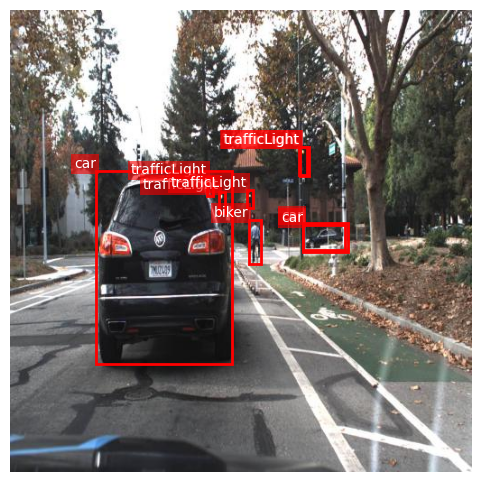

In [9]:
rand_idx = np.random.randint(0, len(train_data))

# set label=False to turn of labels
# set lw=0 to turn off bounding boxes
train_data.show_with_box(index=rand_idx, color='r', lw=2, label=True);

What is the class distribution?

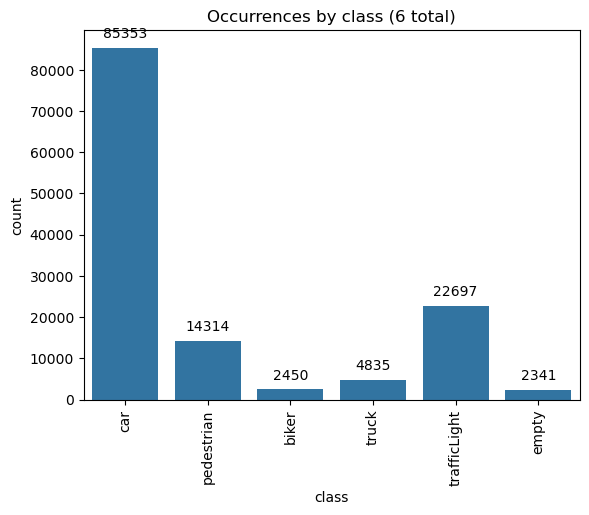

In [3]:
df = train_data.annotate_df

ax = sns.countplot(x=df['class'])

# Annotate counts above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count), 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position
        ha='center', va='bottom',                         # alignment
        xytext=(0, 5), textcoords='offset points'         # offset above bar
    )

plt.xticks(rotation=90)
plt.title(f"Occurrences by class ({len(df['class'].unique())} total)")
plt.show()

Class distribution is unbalanced!

In [11]:
overall_total = len(df)
for class_name in df['class'].unique().tolist():
    class_total = len(df[df['class'] == class_name])
    print(f"The {class_name} class is {(class_total / overall_total) * 100:.2f} percent of all classes present.")
    print()

The car class is 64.67 percent of all classes present.

The pedestrian class is 10.84 percent of all classes present.

The biker class is 1.86 percent of all classes present.

The truck class is 3.66 percent of all classes present.

The trafficLight class is 17.20 percent of all classes present.

The empty class is 1.77 percent of all classes present.



What is the distribution of objects per image?

In [34]:
df_obj_count = pd.DataFrame({"num_objects": np.concatenate((df[df['class'] != 'empty']['filename'].value_counts().to_numpy(),
                                                            np.zeros(len(df[df['class'] == 'empty']),dtype=int)))})

df_obj_count['num_objects'].describe()

count    19862.00000
mean         6.52749
std          5.17792
min          0.00000
25%          2.00000
50%          6.00000
75%          9.00000
max         32.00000
Name: num_objects, dtype: float64

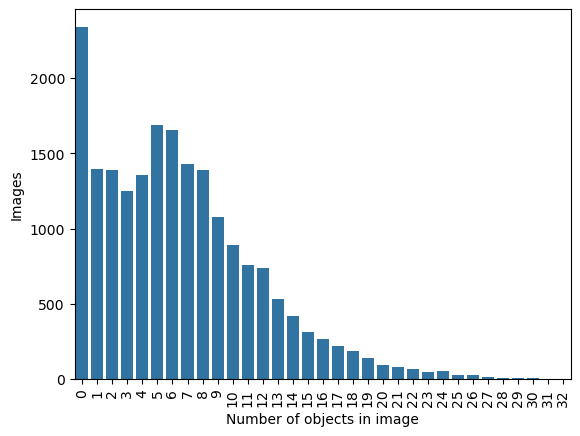

In [32]:
ax = sns.countplot(x=df_obj_count['num_objects'])

plt.xlabel("Number of objects in image")
plt.ylabel("Images")
plt.xticks(rotation=90)

plt.show()

What are the sizes of typical bounding boxes in this dataset?

In [12]:
# Get areas and area percentage of each bounding box
df = train_data.annotate_df
df['area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
df['area_pct'] = df['area'] / (512 * 512)

df['area_pct'].describe()

count    129649.000000
mean          0.012420
std           0.031677
min           0.000015
25%           0.001419
50%           0.003090
75%           0.008694
max           0.514893
Name: area_pct, dtype: float64

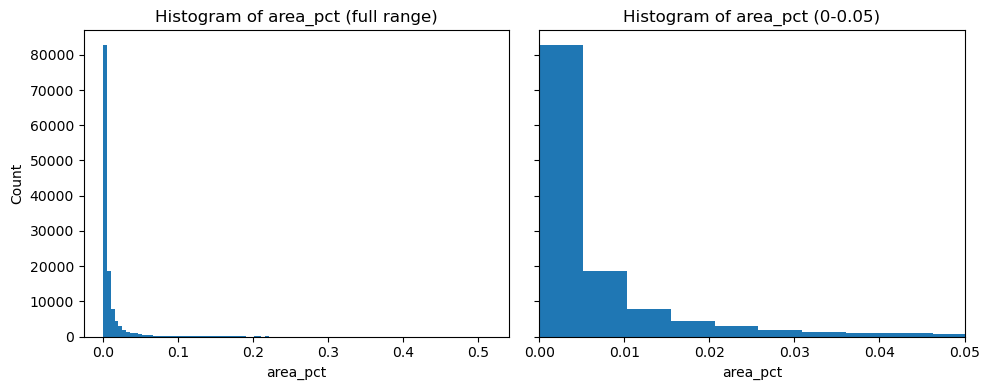

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Left: full range
axes[0].hist(df["area_pct"], bins=100)
axes[0].set_xlabel("area_pct")
axes[0].set_ylabel("Count")
axes[0].set_title("Histogram of area_pct (full range)")

# Right: zoomed in
axes[1].hist(df["area_pct"], bins=100)
axes[1].set_xlim(0, 0.05)  # zoom on main mass
axes[1].set_xlabel("area_pct")
axes[1].set_title("Histogram of area_pct (0-0.05)")

plt.tight_layout()
plt.show()

We can see that the vast majority of bounding boxes are small.

In [14]:
min_CIOU_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),

    ConditionalIoUCrop(min_area_frac=0.02,   # 1% threshold between "large" and "small"
                       small_min_scale=0.4,
                       large_min_scale=0.7,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.Resize((512, 512), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data_CIOUtfms = CarImageClass.ImageClass(targ_dir=train_path, file_list=None, transform=min_CIOU_tfms, file_pct=1, rand_seed=724, include_area=True)

In [15]:
area_list_final = torch.cat(
    [train_data_CIOUtfms[i][1]["areas"] / (512 * 512) for i in range(len(train_data_CIOUtfms))],
    dim=0,
).tolist()

tfm_df = pd.DataFrame({"area_pct": area_list_final})

In [16]:
# describe summaries
orig_desc = df["area_pct"].describe()
tfm_desc  = tfm_df["area_pct"].describe()

# which statistics to compare
stats = ["count", "mean", "min", "25%", "50%", "75%", "max"]

for key in stats:
    orig = float(orig_desc[key])
    tfm  = float(tfm_desc[key])
    # avoid division by zero; if orig == 0, just report absolute change
    if orig != 0:
        pct_change = (tfm - orig) / orig * 100.0
        print(f"{key:>4}: {orig:.6f} -> {tfm:.6f} ({pct_change:+.1f}%)")
    else:
        abs_change = tfm - orig
        print(f"{key:>4}: {orig:.6f} -> {tfm:.6f} (Δ {abs_change:.6f})")


count: 129649.000000 -> 120143.000000 (-7.3%)
mean: 0.012420 -> 0.015502 (+24.8%)
 min: 0.000015 -> 0.000015 (+0.0%)
 25%: 0.001419 -> 0.001685 (+18.7%)
 50%: 0.003090 -> 0.003805 (+23.2%)
 75%: 0.008694 -> 0.010695 (+23.0%)
 max: 0.514893 -> 0.692722 (+34.5%)


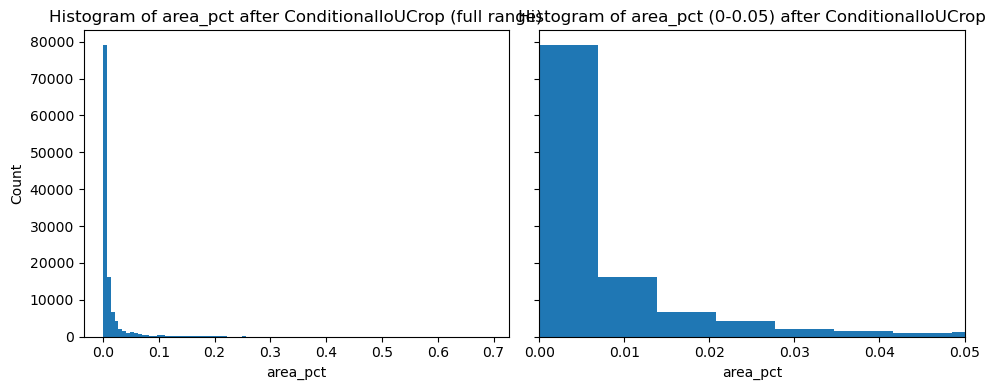

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Left: full range
axes[0].hist(area_list_final, bins=100)
axes[0].set_xlabel("area_pct")
axes[0].set_ylabel("Count")
axes[0].set_title("Histogram of area_pct after ConditionalIoUCrop (full range)")

# Right: zoomed in
axes[1].hist(area_list_final, bins=100)
axes[1].set_xlim(0, 0.05)  # zoom on main mass
axes[1].set_xlabel("area_pct")
axes[1].set_title("Histogram of area_pct (0-0.05) after ConditionalIoUCrop")

plt.tight_layout()
plt.show()

In [46]:
def plot_lr_vs_batch(
    optimizer: torch.optim.Optimizer,
    scheduler,
    num_epochs: int,
    steps_per_epoch: int,
) -> None:
    """
    Plot learning rate vs global batch index, with epoch boundaries annotated.

    Assumptions:
      - scheduler.step() is called ONCE PER BATCH
      - optimizer.param_groups[0]["lr"] is the LR you care about
    """
    lrs = []
    steps = []

    global_step = 0
    for epoch in range(num_epochs):
        for step_in_epoch in range(steps_per_epoch):
            # record current LR before stepping
            current_lr = optimizer.param_groups[0]["lr"]
            lrs.append(current_lr)
            steps.append(global_step)

            # advance scheduler one batch
            scheduler.step()
            global_step += 1

    fig, ax = plt.subplots()
    ax.plot(steps, lrs)
    ax.set_xlabel("global batch (step)")
    ax.set_ylabel("learning rate")

    # epoch boundaries in terms of global steps
    epoch_boundaries = [e * steps_per_epoch for e in range(num_epochs + 1)]
    ax.set_xticks(epoch_boundaries)
    ax.set_xticklabels([str(e) for e in range(num_epochs + 1)])
    ax.set_title("Learning rate vs. batch (ticks = epoch indices)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    fig.tight_layout()


In [48]:
from SSD_from_scratch import mySSD
from torch.utils.data import DataLoader
from SSD_trainer import collate_detection, build_optimizer_and_scheduler

ssdtestmodel = mySSD(in_channels=3, num_classes=6, variances=(0.1, 0.2)).to(device)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.RandomZoomOut(fill=0, p=0.5),       # Zoom out likey hurts model performance

    ConditionalIoUCrop(min_area_frac=0.02,   # 1% threshold between "large" and "small"
                       small_min_scale=0.4,
                       large_min_scale=0.7,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# need to put dataloaders on cpu to use pin_memory
train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set,
                                                           test_size=0.25,
                                                           rand_state=724,
                                                           transform_train=train_tfms,
                                                           transform_test=test_tfms,
                                                           include_area=False)


if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 16
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=2,
                              pin_memory=True,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            persistent_workers=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            collate_fn=collate_detection
                            )

optimizer, scheduler = build_optimizer_and_scheduler(model=ssdtestmodel,
                                                     train_dataloader=train_dataloader,
                                                     max_epochs=150,
                                                     warmup_epochs=5,
                                                     base_lr=0.003,
                                                     min_lr=1e-6,
                                                     momentum=0.9,
                                                     weight_decay=0.005)

c:\Users\eblac\anaconda3\envs\torchCPUenv\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


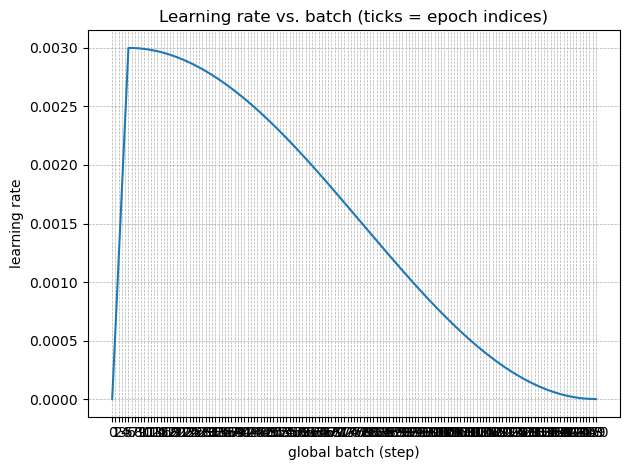

In [49]:
plot_lr_vs_batch(
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=150,
    steps_per_epoch=len(train_dataloader),
)